In [1]:
import sys
import os

import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm


In [2]:
import fiona

# to see if FlatGeoBuf is already supported in your Python env, if not choose the GPKG files, try with QGIS as well for fun :-)
fiona.supported_drivers

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

In [3]:
# world_countries NaturalEarth\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp
world_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_3558/2492467485.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [4]:
# FlatGeoBuf is a new and very compact vector format, a little experimental and really only supported since a year or max. two
# so I provide FlatGeoBuf (fgb) and geopackage for same

# attributes:
# crossed - true/false if crossed the dateline, can't plot those correctly in most GIS tools
# area - m2
# perimeter - m2
# ipq - "standard compactness",  isoperimetric inequality (IPQ) Ossermann 1978 
# zsc - Zone standardised compactness (ZSC) - on the sphere, don't use, I left it in
# lon - longitude of cell centroid
# lat - latitude of cell centroid

print_data = [
# 'DGGRID_FULLER3H_6_LAEA_step2.fgb',
# 'DGGRID_FULLER4D_6_LAEA_step2.fgb', # (4,5?)
# 'DGGRID_FULLER4T_5_LAEA_step2.fgb',
# 'DGGRID_FULLER7H_4_LAEA_step2.fgb',
# 'DGGRID_ISEA3H_6_LAEA_step2.fgb',
# 'DGGRID_ISEA4D_6_LAEA_step2.fgb',
# 'DGGRID_ISEA4T_5_LAEA_step2.fgb',
# 'DGGRID_ISEA7H_4_LAEA_step2.fgb',
# 'eaggr_ISEA3H_3_LAEA_step2.fgb', # (probably rubbish and duplicates)
# 'eaggr_ISEA4T_5_LAEA_step2.fgb',
# 'h3_3_LAEA_step2.fgb',
# 'rhpix_4_LAEA_step2.fgb',
# 's2_6_LAEA_step2.fgb',
'healpy_6_LAEA_step2.fgb',
]

datafile = print_data[0]

In [29]:
grid = gpd.read_file("../cell_stats/results_healpy/" + datafile)

grid[["perimeter", "area", "ipq"]].describe()

,perimeter,area,ipq
count,49152.000000,4.915200e+04,49152.000000
mean,418694.731178,1.037696e+10,0.746612
std,15750.835587,4.369455e+07,0.049278
min,403907.089094,9.426691e+09,0.428177
25%,408071.313295,1.033954e+10,0.727693
50%,409510.842069,1.036453e+10,0.774231
75%,424084.591661,1.040944e+10,0.780574
max,550560.890981,1.052827e+10,0.785398


In [30]:
grid.sample(5)

,cell_id,crossed,area,perimeter,ipq,zsc,lon,lat,geometry
16334,28407,False,1.036034e+10,407777.944385,0.782954,0.884838,170.15625,27.954596,"POLYGON ((170.15625 28.63099, 169.45312 27.953..."
14792,5036,False,1.036785e+10,409089.781758,0.778505,0.882320,126.56250,30.693251,"POLYGON ((126.56250 31.38817, 125.85938 30.691..."
36201,26612,False,1.033945e+10,407513.880503,0.782389,0.884518,-156.09375,16.335482,"POLYGON ((-156.09375 16.95776, -156.79688 16.3..."
11974,40951,False,1.033055e+10,409478.903930,0.774231,0.879895,136.40625,-1.790850,"POLYGON ((136.40625 -1.19375, 135.70312 -1.790..."
12828,28340,False,1.034816e+10,406978.218707,0.785110,0.886055,164.53125,21.382878,"POLYGON ((164.53125 22.02431, 163.82812 21.381..."


In [31]:
# remove bogus cells for nice plotting
grid = grid[~grid['crossed']].dropna(subset=["perimeter", "area", "ipq"])

grid[["perimeter", "area", "ipq"]].describe()

,perimeter,area,ipq
count,48897.000000,4.889700e+04,48897.000000
mean,418400.799311,1.037689e+10,0.747450
std,15082.665387,4.317157e+07,0.047733
min,403917.851598,9.426912e+09,0.591701
25%,408062.257028,1.033954e+10,0.727693
50%,409504.830318,1.036442e+10,0.774330
75%,423708.274066,1.040922e+10,0.781034
max,469907.898316,1.052827e+10,0.785398


In [32]:
# for the normalised area
grid['norm_area'] = grid['area']/grid['area'].mean()

In [33]:
grid[["perimeter", "area", "ipq", "norm_area"]].describe()

,perimeter,area,ipq,norm_area
count,48897.000000,4.889700e+04,48897.000000,48897.000000
mean,418400.799311,1.037689e+10,0.747450,1.000000
std,15082.665387,4.317157e+07,0.047733,0.004160
min,403917.851598,9.426912e+09,0.591701,0.908453
25%,408062.257028,1.033954e+10,0.727693,0.996401
50%,409504.830318,1.036442e+10,0.774330,0.998798
75%,423708.274066,1.040922e+10,0.781034,1.003116
max,469907.898316,1.052827e+10,0.785398,1.014589


In [34]:
grid.loc[grid["norm_area"] > 1.3]

,cell_id,crossed,area,perimeter,ipq,zsc,lon,lat,geometry,norm_area


In [35]:
grid.loc[grid["norm_area"] < 0.5]

,cell_id,crossed,area,perimeter,ipq,zsc,lon,lat,geometry,norm_area


/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_3558/876098978.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(grid[~grid['crossed']],x="norm_area", ax=ax, bins=50, palette="deep")


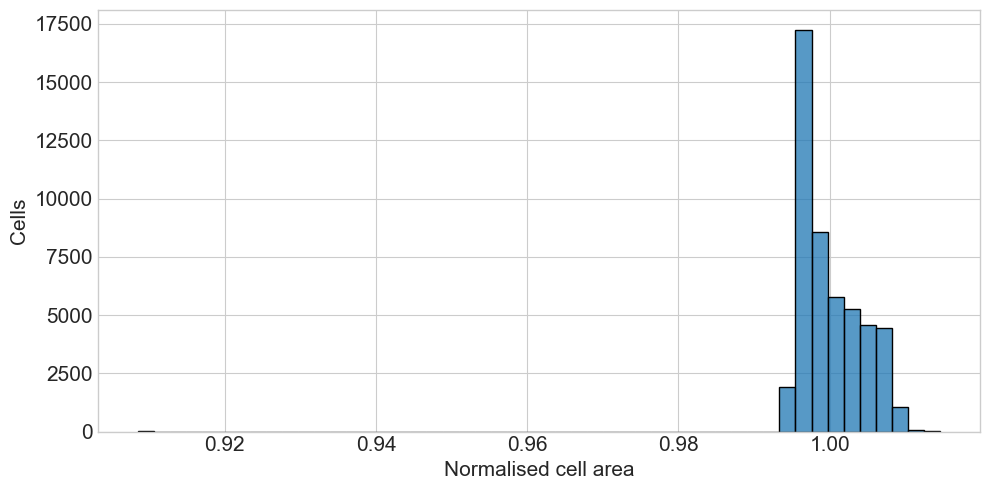

In [36]:
# the normalised area histograms
fig, ax = plt.subplots(figsize=(10,5))

# there are outliers, presumably from wrong calculation for dateline crossed cells
sns.histplot(grid[~grid['crossed']],x="norm_area", ax=ax, bins=50, palette="deep")

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Normalised cell area', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_area.png', bbox_inches="tight",dpi=300)

/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_3558/326444087.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_3558/326444087.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  spec_cmap = cm.get_cmap('RdYlBu_r', len(n))


0.9084527379861941
1.0145886009824279
[0.7        0.71016949 0.72033898 0.73050847 0.74067797 0.75084746
 0.76101695 0.77118644 0.78135593 0.79152542 0.80169492 0.81186441
 0.8220339  0.83220339 0.84237288 0.85254237 0.86271186 0.87288136
 0.88305085 0.89322034 0.90338983 0.91355932 0.92372881 0.93389831
 0.9440678  0.95423729 0.96440678 0.97457627 0.98474576 0.99491525
 1.00508475 1.01525424 1.02542373 1.03559322 1.04576271 1.0559322
 1.06610169 1.07627119 1.08644068 1.09661017 1.10677966 1.11694915
 1.12711864 1.13728814 1.14745763 1.15762712 1.16779661 1.1779661
 1.18813559 1.19830508 1.20847458 1.21864407 1.22881356 1.23898305
 1.24915254 1.25932203 1.26949153 1.27966102 1.28983051 1.3       ]
20
31
[20 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 22 23 23 23 23 23 24 24
 24 24 24 25 25 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28 28
 28 29 29 29 29 29 30 30 30 30 30 31]


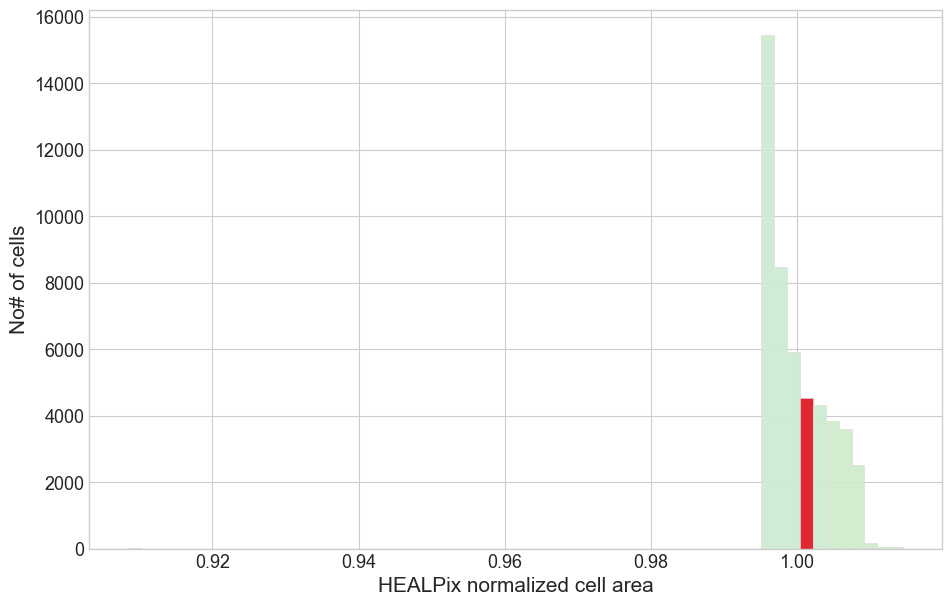

In [65]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
def find_nearest(array, value, as_idx=False):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if as_idx:
        return idx
    else:
        return array[idx]


# the normalised area histograms
fig, ax = plt.subplots(figsize=(11,7))

# there are outliers, presumably from wrong calculation for dateline crossed cells
patches = plt.hist(data=grid,x="norm_area", bins=60, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
plt.style.use('seaborn-whitegrid')

n, bins, patches = plt.hist(data=grid[~grid['crossed']],x="norm_area", bins=60, edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer

bin_df = pd.DataFrame({ "bin_vals": np.abs(1-bins)})
min_idx = bin_df.loc[bin_df["bin_vals"] == bin_df["bin_vals"].min()].index[0]

vmin, vmax, vcenter = 0.7, 1.3, 1
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

spec_cmap = cm.get_cmap('RdYlBu_r', len(n))
norm_cmap = spec_cmap(norm(np.linspace(vmin, vmax, len(n))))

a_vmin = bins.min()
a_vmax = bins.max()
print(a_vmin)
print(a_vmax)

syn_list = np.linspace(vmin, vmax, len(n))

print(syn_list)

cut_vmin = find_nearest(syn_list, a_vmin, as_idx=True)
cut_vmax = find_nearest(syn_list, a_vmax, as_idx=True)

print(cut_vmin)
print(cut_vmax)

act_list = np.linspace(cut_vmin, cut_vmax, len(n)).astype(int)
print(act_list)

# Good old loop. Choose colormap of your taste
# spec_cmap(  bins[i] / max(bins))
for i in range(len(patches)):
    patches[i].set_facecolor(norm_cmap[act_list[i]])
# Make one bin stand out   
patches[min_idx].set_fc('red') # Set color
patches[min_idx].set_alpha(0.8) # Set opacity

# Add annotation
# plt.annotate('no distortion', xy=(1.0, 1300), xytext=(1.1, 1500), fontsize=12, arrowprops={'width':0.3,'headwidth':6,'color':'#333333'})
#plt.title(title') 

plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel('HEALPix normalized cell area', fontsize=15) 
plt.ylabel('No# of cells', fontsize=15) 
#plt.show()
plt.savefig("../cell_stats/results_healpy/healpy_area_hist.png", bbox_inches="tight",dpi=300)

In [39]:
norm(np.linspace(0.5, 1.3, 60))

masked_array(data=[      -inf,       -inf,       -inf,       -inf,
                         -inf,       -inf,       -inf,       -inf,
                         -inf,       -inf,       -inf,       -inf,
                         -inf,       -inf,       -inf, 0.00564972,
                   0.02824859, 0.05084746, 0.07344633, 0.0960452 ,
                   0.11864407, 0.14124294, 0.16384181, 0.18644068,
                   0.20903955, 0.23163842, 0.25423729, 0.27683616,
                   0.29943503, 0.3220339 , 0.34463277, 0.36723164,
                   0.38983051, 0.41242938, 0.43502825, 0.45762712,
                   0.48022599, 0.50282486, 0.52542373, 0.5480226 ,
                   0.57062147, 0.59322034, 0.61581921, 0.63841808,
                   0.66101695, 0.68361582, 0.70621469, 0.72881356,
                   0.75141243, 0.7740113 , 0.79661017, 0.81920904,
                   0.84180791, 0.86440678, 0.88700565, 0.90960452,
                   0.93220339, 0.95480226, 0.97740113, 1.     

In [40]:
np.linspace(cut_vmin, cut_vmax, len(n)).astype(int)

array([20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22,
       23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26,
       26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29,
       29, 29, 29, 30, 30, 30, 30, 30, 31])

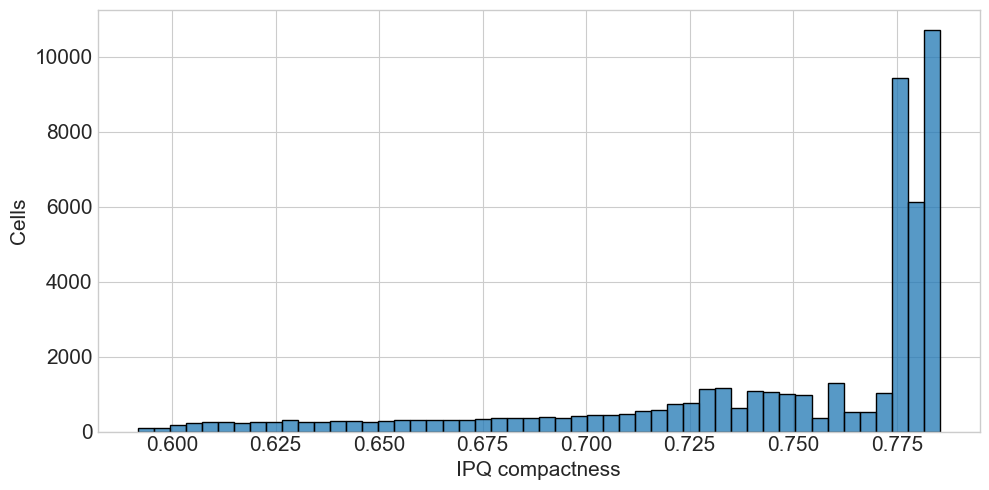

In [41]:
# the important IPQ compactness histograms
fig, ax = plt.subplots(figsize=(10,5))

# there are outliers, presumably from wrong calculation for dateline crossed cells
sns.histplot(grid[~grid['crossed']],x="ipq", ax=ax, bins=50)
# sns.histplot(grid,x="ipq", ax=ax, bins=50)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('IPQ compactness', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
plt.savefig("../cell_stats/results_healpy/healpy_compactness_hist.png", bbox_inches="tight",dpi=300)

/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_3558/3636947727.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_3558/3636947727.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  spec_cmap = cm.get_cmap('viridis', len(n))


0.5917012521103615
0.7853978731686243
[0.6        0.60338983 0.60677966 0.61016949 0.61355932 0.61694915
 0.62033898 0.62372881 0.62711864 0.63050847 0.63389831 0.63728814
 0.64067797 0.6440678  0.64745763 0.65084746 0.65423729 0.65762712
 0.66101695 0.66440678 0.66779661 0.67118644 0.67457627 0.6779661
 0.68135593 0.68474576 0.68813559 0.69152542 0.69491525 0.69830508
 0.70169492 0.70508475 0.70847458 0.71186441 0.71525424 0.71864407
 0.7220339  0.72542373 0.72881356 0.73220339 0.73559322 0.73898305
 0.74237288 0.74576271 0.74915254 0.75254237 0.7559322  0.75932203
 0.76271186 0.76610169 0.76949153 0.77288136 0.77627119 0.77966102
 0.78305085 0.78644068 0.78983051 0.79322034 0.79661017 0.8       ]
0
55
[ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 13 14 15 16 17 18 19 20 21
 22 23 24 25 26 27 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55]


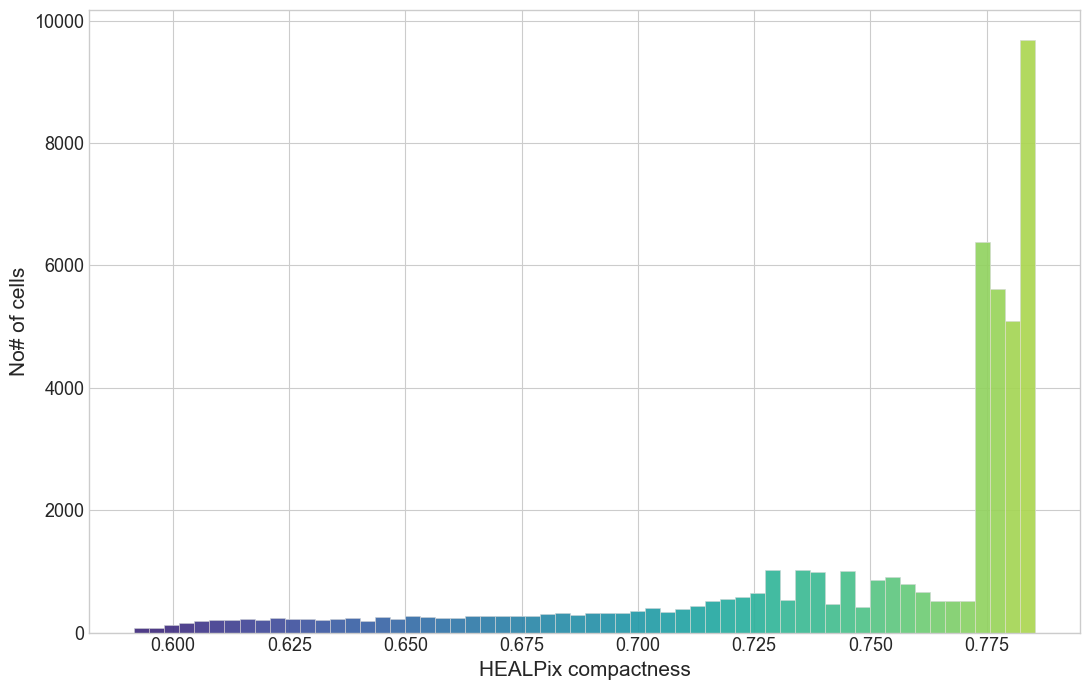

In [64]:
# the normalised area histograms
fig, ax = plt.subplots(figsize=(11,7))

# there are outliers, presumably from wrong calculation for dateline crossed cells
patches = plt.hist(data=grid,x="ipq", bins=60, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
plt.style.use('seaborn-whitegrid')

n, bins, patches = plt.hist(data=grid[~grid['crossed']],x="ipq", bins=60, edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer

bin_df = pd.DataFrame({ "bin_vals": np.abs(1-bins)})
min_idx = bin_df.loc[bin_df["bin_vals"] == bin_df["bin_vals"].min()].index[0]

vmin, vmax, vcenter = 0.6, 0.8, 0.7
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

spec_cmap = cm.get_cmap('viridis', len(n))
norm_cmap = spec_cmap(norm(np.linspace(vmin, vmax, len(n))))

a_vmin = bins.min()
a_vmax = bins.max()
print(a_vmin)
print(a_vmax)

syn_list = np.linspace(vmin, vmax, len(n))

print(syn_list)

cut_vmin = find_nearest(syn_list, a_vmin, as_idx=True)
cut_vmax = find_nearest(syn_list, a_vmax, as_idx=True)

print(cut_vmin)
print(cut_vmax)

act_list = np.linspace(cut_vmin, cut_vmax, len(n)).astype(int)
print(act_list)

# Good old loop. Choose colormap of your taste
# spec_cmap(  bins[i] / max(bins))
for i in range(len(patches)):
    patches[i].set_facecolor(norm_cmap[act_list[i]])
# Make one bin stand out   
# patches[min_idx].set_fc('red') # Set color
# patches[min_idx].set_alpha(0.8) # Set opacity

# Add annotation
# plt.annotate('no distortion', xy=(1.0, 1300), xytext=(1.1, 1500), fontsize=12, arrowprops={'width':0.3,'headwidth':6,'color':'#333333'})
#plt.title(title') 

plt.tick_params(axis='both', which='major', labelsize=13)
plt.xlabel('HEALPix compactness', fontsize=15) 
plt.ylabel('No# of cells', fontsize=15)
plt.tight_layout()
plt.savefig("../cell_stats/results_healpy/healpy_compactness_hist.png", bbox_inches="tight",dpi=300)

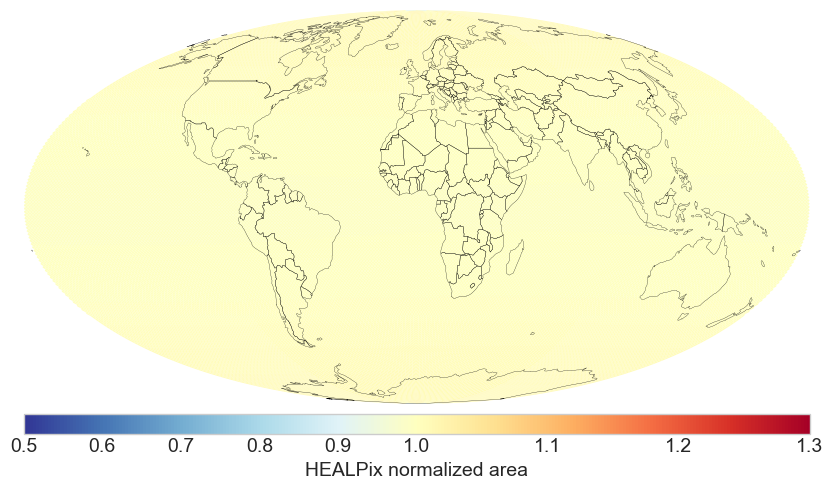

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# the vmin/vmax boundaries for all plots I have to determine based on the stats which I currently calculate
# vmin, vmax, vcenter = grid['norm_area'].min(), grid['norm_area'].max(), 1
vmin, vmax, vcenter = 0.5, 1.3, 1
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# plots get messed up for dateline crossed cells
grid[~grid['crossed']].to_crs('proj=moll').plot(column='norm_area', ax=ax, norm=norm, legend=True,cax=cax, cmap='RdYlBu_r', legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
# grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, legend=True,cax=cax, cmap='RdYlBu_r', legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})

world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "HEALPix normalized area",fontsize=14)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig("../cell_stats/results_healpy/healpy_area_map.png", bbox_inches="tight",dpi=300)


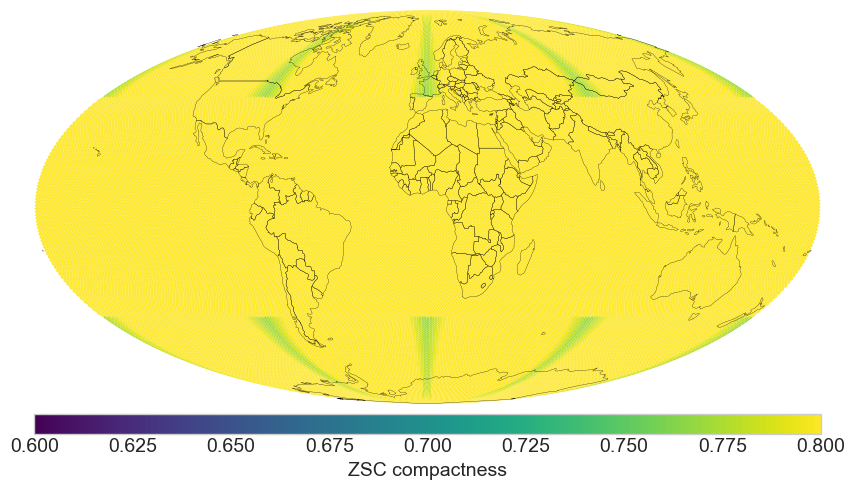

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

vmin = 0.6
vmax = 0.8

grid[~grid['crossed']].to_crs('proj=moll').plot(column='zsc', ax=ax, vmin=vmin, vmax=vmax, legend=True,cax=cax, cmap='viridis', legend_kwds={'label': "zonal standardized compactness",'orientation': "horizontal"})
# grid.to_crs('proj=moll').plot(column='zsc', ax=ax, legend=True,cax=cax, legend_kwds={'label': "zonal standadized compactness",'orientation': "horizontal"})

world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "ZSC compactness",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_compactness_map.png', bbox_inches="tight",dpi=300)

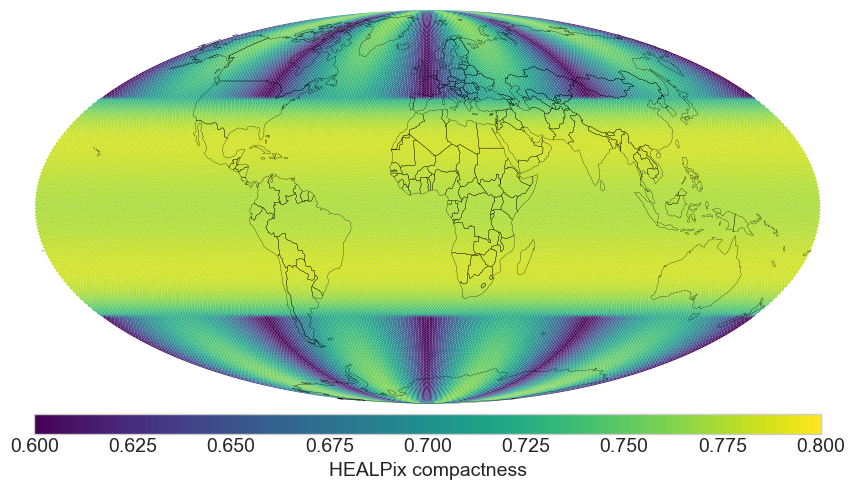

In [56]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

grid[~grid['crossed']].to_crs('proj=moll').plot(column='ipq', ax=ax, vmin=vmin, vmax=vmax, legend=True,cax=cax, cmap='viridis', legend_kwds={'label': "IPQ compactness",'orientation': "horizontal"})
# grid.to_crs('proj=moll').plot(column='zsc', ax=ax, legend=True,cax=cax, legend_kwds={'label': "zonal standadized compactness",'orientation': "horizontal"})

world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "HEALPix compactness",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig("../cell_stats/results_healpy/healpy_compactness_map.png", bbox_inches="tight",dpi=300)